In [149]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA,TruncatedSVD,NMF
from sklearn.preprocessing import Normalizer
import argparse
import time
import dask
import pickle as pkl
import dask.dataframe as dd
import numba
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None
from functools import reduce
import matplotlib
#matplotlib.use('agg')
matplotlib.style.use('ggplot')
from matplotlib import pyplot as plt
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)

In [151]:
br_to_us=pd.read_excel("Book.xlsx",skiprows=[0])
br_to_us_dict=dict(zip(br_to_us.UK.tolist(),br_to_us.US.tolist()))
spelling_replacement={'modifier':br_to_us_dict,'head':br_to_us_dict}

In [147]:
def lemma_maker(x, y):
    #print(lemmatizer(x,y)[0])
    return lemmatizer(x,y)[0]

In [62]:
heads=pd.read_pickle("/data/dharp/compounding/datasets/heads_CompoundCentric_DecadeCentric_300.pkl")
#heads.reset_index(inplace=True)
#heads=heads.drop(['decade'],axis=1).groupby(['head']).mean()
heads=heads+1
heads.index.set_names('time', level=1,inplace=True)
heads.info()
heads.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 586758 entries, (a_n, 1800) to (zygote_n, 1990)
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 1.3+ GB


0         1         2         3         4         5    \
head time                                                               
a_n  1800  0.312933 -0.017511 -0.017429 -0.010605 -0.010299  0.088677   
     1810  0.229060 -0.016928 -0.006156 -0.007647 -0.011307  0.095756   
     1820  0.336609 -0.021739 -0.024288 -0.010907 -0.014429  0.123659   
     1830  0.440246 -0.028305 -0.028136 -0.015908 -0.020206  0.189441   
     1840  0.607442 -0.035494 -0.056402 -0.024072 -0.028337  0.239621   

                6         7         8         9    ...       290       291  \
head time                                          ...                       
a_n  1800  0.004979 -0.011777 -0.000650 -0.086263  ... -0.064543  0.022012   
     1810  0.006723 -0.013566  0.012587 -0.095314  ... -0.030957 -0.060872   
     1820  0.007318 -0.018282  0.003044 -0.112993  ... -0.034306 -0.050141   
     1830  0.008040 -0.030106  0.001027 -0.143018  ... -0.048084 -0.026920   
     1840 -0.003095 -0.035200 -0.011063 -0.204627  ... -0.054571 -0.008243   

                292       293       294       295       296       297  \
head time                                                               
a_n  1800  0.035193  0.091496  0.083806  0.037728  0.016246  0.033656   
     1810  0.022912  0.128627  0.178999  0.073649 -0.035067  0.029017   
     1820  0.000557  0.104872  0.154516  0.063607 -0.035870  0.025759   
     1830 -0.007645  0.086015  0.118038  0.068793  0.005827  0.022377   
     1840  0.019045  0.070371  0.082684  0.060930  0.002884  0.023896   

                298       299  
head time                      
a_n  1800  0.004187 -0.128597  
     1810 -0.015710 -0.038057  
     1820 -0.002428 -0.041312  
     1830 -0.006011 -0.056380  
     1840 -0.010213 -0.058617  

[5 rows x 300 columns]

In [99]:
modifiers=pd.read_pickle("/data/dharp/compounding/datasets/modifiers_CompoundCentric_DecadeCentric_300.pkl")
#heads.reset_index(inplace=True)
#heads=heads.drop(['decade'],axis=1).groupby(['head']).mean()
#modifiers=modifiers+1
modifiers.index.set_names('time', level=1,inplace=True)
modifiers.info()
modifiers.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 514067 entries, (a_n, 1800) to (zylobalsamum_n, 1990)
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 1.2+ GB


0      1      2      3      4     5      6      7      8    \
modifier time                                                                
a_n      1800 0.531 -0.038 -0.056 -0.024 -0.029 0.225 -0.013 -0.029 -0.016   
         1810 0.440 -0.032 -0.051 -0.019 -0.023 0.162 -0.007 -0.021 -0.016   
         1820 0.226 -0.016 -0.022 -0.009 -0.013 0.099 -0.002 -0.011  0.006   
         1830 0.105 -0.007 -0.010 -0.004 -0.006 0.048 -0.000 -0.005  0.008   
         1840 0.086 -0.007 -0.007  0.019 -0.011 0.015  0.001 -0.001  0.001   

                 9    ...    290   291   292   293    294    295   296    297  \
modifier time         ...                                                       
a_n      1800 -0.191  ... -0.038 0.051 0.023 0.006 -0.028  0.016 0.052  0.009   
         1810 -0.140  ... -0.020 0.066 0.038 0.017 -0.041 -0.045 0.078 -0.007   
         1820 -0.089  ... -0.008 0.098 0.063 0.034 -0.060 -0.110 0.115 -0.024   
         1830 -0.045  ... -0.003 0.098 0.067 0.033 -0.058 -0.117 0.123 -0.029   
         1840 -0.017  ... -0.003 0.098 0.066 0.029 -0.059 -0.118 0.125 -0.029   

                 298    299  
modifier time                
a_n      1800  0.002 -0.096  
         1810 -0.031 -0.174  
         1820 -0.068 -0.283  
         1830 -0.077 -0.292  
         1840 -0.078 -0.291  

[5 rows x 300 columns]

In [74]:
compounds=pd.read_pickle("/data/dharp/compounding/datasets/compounds_CompoundCentric_DecadeCentric_300.pkl")
#heads.reset_index(inplace=True)
#heads=heads.drop(['decade'],axis=1).groupby(['head']).mean()
compounds.index.set_names('time', level=2,inplace=True)
compounds.drop(['common'],axis=1,inplace=True)
#compounds=compounds+1
#compounds.reset_index(inplace=True)
compounds.info()
compounds.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3781847 entries, (a_n, aaaaa_n, 1960) to (zylobalsamum_n, process_n, 1920)
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 8.5+ GB


0         1         2         3         4    \
modifier head      time                                                     
a_n      aaaaa_n   1960  0.001559 -0.000158  0.000625  0.000832 -0.000796   
                   1970  0.001559 -0.000158  0.000625  0.000832 -0.000796   
                   1980  0.001559 -0.000158  0.000625  0.000832 -0.000796   
                   1990  0.001559 -0.000158  0.000625  0.000832 -0.000796   
         addison_n 1960  0.011834 -0.002478  0.043566 -0.002515  0.001779   

                              5         6         7         8         9    \
modifier head      time                                                     
a_n      aaaaa_n   1960  0.004964  0.000146 -0.000465  0.002441 -0.007268   
                   1970  0.004964  0.000146 -0.000465  0.002441 -0.007268   
                   1980  0.004964  0.000146 -0.000465  0.002441 -0.007268   
                   1990  0.004964  0.000146 -0.000465  0.002441 -0.007268   
         addison_n 1960 -0.007481  0.004700 -0.000858  0.031843  0.002619   

                         ...       290       291       292       293  \
modifier head      time  ...                                           
a_n      aaaaa_n   1960  ... -0.063368  0.120493  0.037918  0.045026   
                   1970  ... -0.063368  0.120493  0.037918  0.045026   
                   1980  ... -0.063368  0.120493  0.037918  0.045026   
                   1990  ... -0.063368  0.120493  0.037918  0.045026   
         addison_n 1960  ... -0.075938 -0.132098 -0.053317 -0.045525   

                              294       295       296       297       298  \
modifier head      time                                                     
a_n      aaaaa_n   1960 -0.030933  0.076486  0.060778  0.095964 -0.030948   
                   1970 -0.030933  0.076486  0.060778  0.095964 -0.030948   
                   1980 -0.030933  0.076486  0.060778  0.095964 -0.030948   
                   1990 -0.030933  0.076486  0.060778  0.095964 -0.030948   
         addison_n 1960 -0.098890  0.043411  0.097561  0.137827 -0.028451   

                              299  
modifier head      time            
a_n      aaaaa_n   1960 -0.158763  
                   1970 -0.158763  
                   1980 -0.158763  
                   1990 -0.158763  
         addison_n 1960 -0.058978  

[5 rows x 300 columns]

In [38]:
compound_decade_counts=compounds.drop(['modifier','head'],axis=1).groupby('time').sum().sum(axis=1).to_frame()
compound_decade_counts.columns=['N']
compound_decade_counts

,N
time,
1800,5.549473e+06
1810,7.238801e+06
1820,1.060945e+07
1830,1.281525e+07
1840,1.552840e+07
1850,2.288116e+07
1860,2.249154e+07
1870,2.695524e+07
1880,3.556327e+07


In [39]:
compounds = dd.from_pandas(compounds, npartitions=30)

In [41]:
XY=compounds.groupby(['modifier','head','time']).sum().sum(axis=1).to_frame()
XY=XY.compute()
XY.columns=['a']

X_star=compounds.groupby(['modifier','time']).sum().sum(axis=1).to_frame()
X_star=X_star.compute()
X_star.columns=['x_star']

Y_star=compounds.groupby(['head','time']).sum().sum(axis=1).to_frame()
Y_star=Y_star.compute()
Y_star.columns=['star_y']


merge1=pd.merge(XY.reset_index(),X_star.reset_index(),on=['modifier','time'])
information_feat=pd.merge(merge1,Y_star.reset_index(),on=['head','time'])

information_feat=dd.from_pandas(information_feat, npartitions=30)
information_feat['b']=information_feat['x_star']-information_feat['a']
information_feat['c']=information_feat['star_y']-information_feat['a']


information_feat=information_feat.compute()
information_feat=pd.merge(information_feat,compound_decade_counts.reset_index(),on=['time'])
information_feat=dd.from_pandas(information_feat, npartitions=30)
information_feat['d']=information_feat['N']-(information_feat['a']+information_feat['b']+information_feat['c'])
information_feat['x_bar_star']=information_feat['N']-information_feat['x_star']
information_feat['star_y_bar']=information_feat['N']-information_feat['star_y']
#information_feat['LR']=-2*np.sum(information_feat['a']*np.log2((information_feat['a']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y'])))

information_feat=information_feat.compute()
information_feat.set_index(['modifier','head','time'],inplace=True)

information_feat.replace(0,0.0001,inplace=True)
information_feat['log_ratio']=2*(information_feat['a']*np.log((information_feat['a']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y']))+\
information_feat['b']*np.log((information_feat['b']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y_bar']))+\
information_feat['c']*np.log((information_feat['c']*information_feat['N'])/(information_feat['x_bar_star']*information_feat['star_y']))+\
information_feat['d']*np.log((information_feat['d']*information_feat['N'])/(information_feat['x_bar_star']*information_feat['star_y_bar'])))
information_feat['ppmi']=np.log2((information_feat['a']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y']))
information_feat['local_mi']=information_feat['a']*information_feat['ppmi']
information_feat.ppmi.loc[information_feat.ppmi<=0]=0
information_feat.drop(['a','x_star','star_y','b','c','d','N','d','x_bar_star','star_y_bar'],axis=1,inplace=True)
information_feat.info()
information_feat.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3781847 entries, (a_n, aaaaa_n, 1960) to (zone_n, homologue_n, 1930)
Data columns (total 3 columns):
log_ratio    float64
ppmi         float64
local_mi     float64
dtypes: float64(3)
memory usage: 119.8+ MB


log_ratio       ppmi     local_mi
modifier    head      time                                     
a_n         aaaaa_n   1960  4688.680508  11.235255  3380.718051
            addison_n 1960  2465.855716   7.322377  2192.017030
adherents_n addison_n 1960  5270.028489  13.558423  4087.861644
college_n   addison_n 1960  1847.026551   5.818874  1741.930201
conceits_n  addison_n 1960  5277.161324  13.562827  4092.725435

In [65]:
modifier_denom=np.square(modifiers).sum(axis=1)**0.5
modifier_denom=modifier_denom.to_frame()
modifier_denom.columns=['modifier_denom']
modifier_denom.info()
modifier_denom.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 514067 entries, (a_n, 1800) to (zylobalsamum_n, 1990)
Data columns (total 1 columns):
modifier_denom    514067 non-null float64
dtypes: float64(1)
memory usage: 9.3+ MB


modifier_denom
modifier time                
a_n      1800             1.0
         1810             1.0
         1820             1.0
         1830             1.0
         1840             1.0

In [66]:
head_denom=np.square(heads).sum(axis=1)**0.5
head_denom=head_denom.to_frame()
head_denom.columns=['head_denom']
head_denom.info()
head_denom.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 586758 entries, (a_n, 1800) to (zygote_n, 1990)
Data columns (total 1 columns):
head_denom    586758 non-null float64
dtypes: float64(1)
memory usage: 10.2+ MB


head_denom
head time            
a_n  1800         1.0
     1810         1.0
     1820         1.0
     1830         1.0
     1840         1.0

In [69]:
compound_denom=np.square(compounds.set_index(['modifier','head','time'])).sum(axis=1)**0.5
compound_denom=compound_denom.to_frame()
compound_denom.columns=['compound_denom']
compound_denom.info()
compound_denom.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3781847 entries, (a_n, aaaaa_n, 1960) to (zylobalsamum_n, process_n, 1920)
Data columns (total 1 columns):
compound_denom    float64
dtypes: float64(1)
memory usage: 62.1+ MB


compound_denom
modifier head      time                
a_n      aaaaa_n   1960             1.0
                   1970             1.0
                   1980             1.0
                   1990             1.0
         addison_n 1960             1.0

In [83]:
#compounds.drop('head',axis=1).set_index(['modifier','time']).multiply(modifiers)
compound_modifier_sim=compounds.multiply(modifiers.drop('mod_count',axis=1).reindex(compounds.index, method='ffill')).sum(axis=1).to_frame()
compound_modifier_sim.columns=['sim_with_modifier']
compound_modifier_sim.info()
compound_modifier_sim.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3781847 entries, (a_n, aaaaa_n, 1960) to (zylobalsamum_n, process_n, 1920)
Data columns (total 1 columns):
sim_with_modifier    float64
dtypes: float64(1)
memory usage: 67.1+ MB


sim_with_modifier
modifier head      time                   
a_n      aaaaa_n   1960             -0.002
                   1970              0.879
                   1980              0.879
                   1990              0.879
         addison_n 1960              0.008

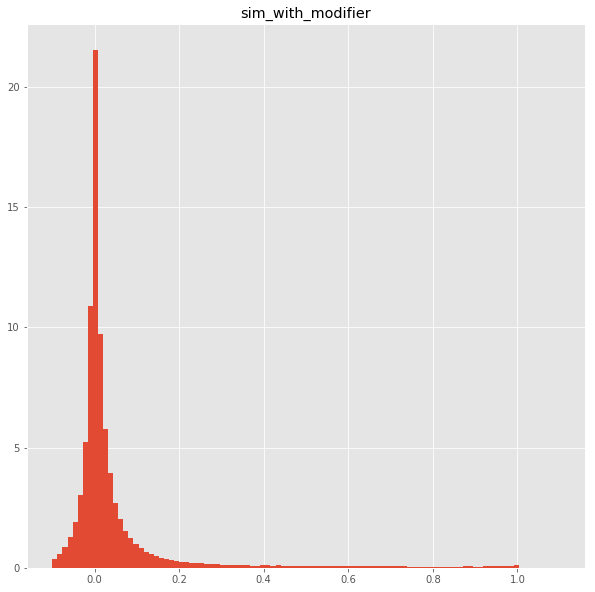

In [86]:
_=compound_modifier_sim.hist(column ='sim_with_modifier', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.1,1.1))

In [88]:
compound_head_sim=compounds.multiply(heads.reindex(compounds.index, method='ffill')).sum(axis=1).to_frame()
compound_head_sim.columns=['sim_with_head']
compound_head_sim.info()
compound_head_sim.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3781847 entries, (a_n, aaaaa_n, 1960) to (zylobalsamum_n, process_n, 1920)
Data columns (total 1 columns):
sim_with_head    float64
dtypes: float64(1)
memory usage: 67.1+ MB


sim_with_head
modifier head      time               
a_n      aaaaa_n   1960         -0.009
                   1970         -0.027
                   1980         -0.027
                   1990         -0.027
         addison_n 1960         -0.014

In [89]:
compound_head_sim.sim_with_head.describe()

count   3781847.000
mean          0.042
std           0.141
min          -0.682
25%          -0.004
50%           0.002
75%           0.030
max           1.000
Name: sim_with_head, dtype: float64

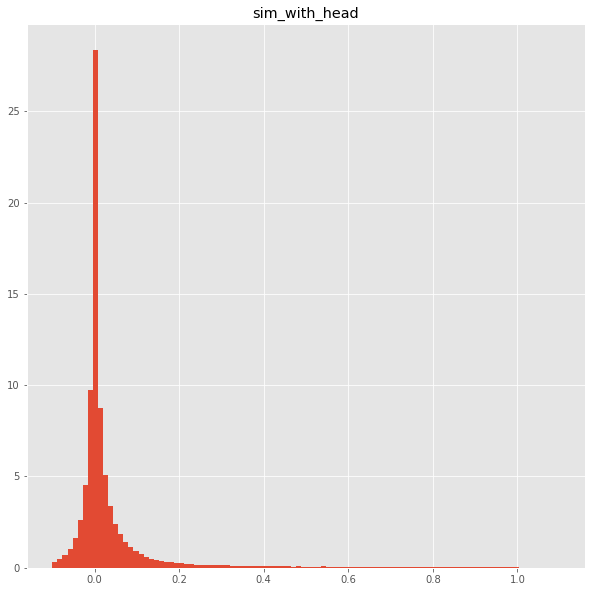

In [90]:
_=compound_head_sim.hist(column ='sim_with_head', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.1,1.1))

In [114]:
constituent_sim=compounds.reset_index()[['modifier','head','time']].merge(modifiers.reset_index(),how='left',on=['modifier','time'])
constituent_sim.set_index(['modifier','head','time'],inplace=True)
constituent_sim=constituent_sim.multiply(heads.reindex(constituent_sim.index, method='ffill')).sum(axis=1).to_frame()
constituent_sim.columns=['sim_bw_constituents']

In [115]:
constituent_sim.sim_bw_constituents.describe()

count   3781847.000
mean          0.112
std           0.211
min          -0.487
25%           0.000
50%           0.017
75%           0.102
max           1.000
Name: sim_bw_constituents, dtype: float64

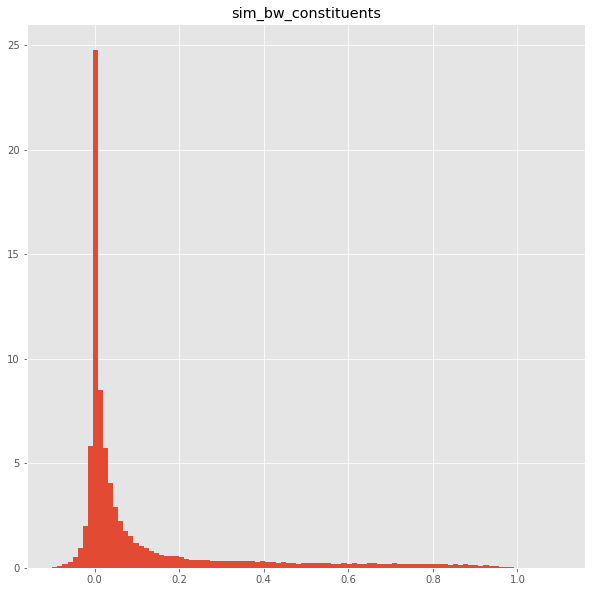

In [116]:
_=constituent_sim.hist(column ='sim_bw_constituents', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.1,1.1))

In [145]:
dfs = [constituent_sim, compound_head_sim, compound_modifier_sim, information_feat]
compounds_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs)
compounds_final=pd.pivot_table(compounds_final.reset_index(), index=['modifier','head'], columns=['time'])
compounds_final.fillna(0,inplace=True)
compounds_final -= compounds_final.min()
compounds_final /= compounds_final.max()
compounds_final_1=compounds_final.columns.get_level_values(0)
compounds_final_2=compounds_final.columns.get_level_values(1)

cur_year=0
new_columns=[]
for year in compounds_final_2:
    new_columns.append(str(year)+"_"+compounds_final_1[cur_year])
    cur_year+=1
compounds_final.columns=new_columns
compounds_final

1800_local_mi  1810_local_mi  1820_local_mi  \
modifier        head                                                          
a_n             aaaaa_n                 0.083          0.082          0.101   
                addison_n               0.083          0.082          0.101   
                anti_n                  0.083          0.082          0.101   
                archive_n               0.083          0.082          0.101   
                atom_n                  0.083          0.082          0.101   
                b_n                     0.566          0.611          0.586   
                ballet_n                0.083          0.082          0.101   
                band_n                  0.083          0.082          0.101   
                baseball_n              0.083          0.082          0.101   
                behavior_n              0.083          0.082          0.101   
                bell_n                  0.083          0.082          0.101   
                belle_n                 0.083          0.082          0.101   
                bend_n                  0.083          0.082          0.101   
                berkley_n               0.083          0.082          0.101   
                bibliography_n          0.083          0.082          0.101   
                bill_n                  0.083          0.082          0.101   
                bird_n                  0.083          0.082          0.101   
                board_n                 0.083          0.082          0.101   
                book_n                  0.083          0.082          0.101   
                boswell_n               0.083          0.082          0.101   
                brand_n                 0.083          0.082          0.101   
                briefe_n                0.083          0.082          0.101   
                bunch_n                 0.083          0.082          0.101   
                burn_n                  0.083          0.082          0.101   
                business_n              0.083          0.082          0.101   
                c_n                     0.613          0.656          0.623   
                calendar_n              0.083          0.082          0.101   
                call_n                  0.083          0.082          0.101   
                campaign_n              0.083          0.082          0.101   
                candle_n                0.083          0.082          0.101   
...                                       ...            ...            ...   
zuni_n          mountain_n              0.083          0.082          0.101   
                origin_n                0.083          0.082          0.101   
                prehistory_n            0.083          0.082          0.101   
                religion_n              0.083          0.082          0.101   
                ruin_n                  0.083          0.082          0.101   
                sacred_n                0.083          0.082          0.101   
                social_n                0.083          0.082          0.101   
                tradition_n             0.083          0.082          0.101   
                tribe_n                 0.083          0.082          0.101   
                village_n               0.083          0.082          0.101   
                war_n                   0.083          0.082          0.101   
                word_n                  0.083          0.082          0.101   
zunyi_n         conference_n            0.083          0.082          0.101   
zurich_n        acm_n                   0.083          0.082          0.101   
                agreement_n             0.083          0.082          0.101   
                chamber_n               0.083          0.082          0.101   
                conference_n            0.083          0.082          0.101   
                government_n            0.083          0.082          0.101   
   

In [159]:
reddy11_study=pd.read_csv("/data/dharp/compounding/datasets/ijcnlp_compositionality_data/MeanAndDeviations.clean.txt",sep="\t")
#print(reddy11_study.columns)
reddy11_study.columns=['compound','to_divide']
reddy11_study['modifier_mean'],reddy11_study['modifier_std'],reddy11_study['head_mean'],reddy11_study['head_std'],reddy11_study['compound_mean'],reddy11_study['compound_std'],_=reddy11_study.to_divide.str.split(" ",7).str
reddy11_study['modifier'],reddy11_study['head']=reddy11_study['compound'].str.split(" ",2).str
reddy11_study.modifier=reddy11_study.modifier.str[:-2]
reddy11_study['head']=reddy11_study['head'].str[:-2]
reddy11_study.drop(['compound','to_divide'],axis=1,inplace=True)
reddy11_study['modifier']=np.vectorize(lemma_maker)(reddy11_study['modifier'],'noun')
reddy11_study['head']=np.vectorize(lemma_maker)(reddy11_study['head'],'noun')
reddy11_study.replace(spelling_replacement,inplace=True)
reddy11_study['modifier']=reddy11_study['modifier']+"_n"
reddy11_study['head']=reddy11_study['head']+"_n"
reddy11_study=reddy11_study.apply(pd.to_numeric, errors='ignore')
#reddy11_study.set_index(['modifier','head'],inplace=True)
reddy11_study.info()
reddy11_study.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 8 columns):
modifier_mean    90 non-null float64
modifier_std     90 non-null float64
head_mean        90 non-null float64
head_std         90 non-null float64
compound_mean    90 non-null float64
compound_std     90 non-null float64
modifier         90 non-null object
head             90 non-null object
dtypes: float64(6), object(2)
memory usage: 5.7+ KB


,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,modifier,head
0,3.867,1.118,4.867,0.340,4.250,0.871,end_n,user_n
1,1.607,1.655,1.893,1.496,1.704,1.717,firing_n,line_n
2,2.821,1.965,4.862,0.345,3.828,1.234,game_n,plan_n
3,4.767,0.423,4.862,0.345,4.800,0.476,application_n,form_n
4,0.600,0.800,4.586,1.099,1.310,1.021,snail_n,mail_n


In [164]:
merge_df=reddy11_study.merge(compounds_final.reset_index(),on=['modifier','head'],how='inner')
merge_df.set_index(["modifier", "head"], inplace = True)
merge_df.info()
merge_df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 70 entries, (end_n, user_n) to (bank_n, account_n)
Columns: 126 entries, modifier_mean to 1990_sim_with_modifier
dtypes: float64(126)
memory usage: 70.2+ KB


,,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,1800_local_mi,1810_local_mi,1820_local_mi,1830_local_mi,...,1900_sim_with_modifier,1910_sim_with_modifier,1920_sim_with_modifier,1930_sim_with_modifier,1940_sim_with_modifier,1950_sim_with_modifier,1960_sim_with_modifier,1970_sim_with_modifier,1980_sim_with_modifier,1990_sim_with_modifier
modifier,head,,,,,,,,,,,,,,,,,,,,,
end_n,user_n,3.867,1.118,4.867,0.340,4.250,0.871,0.083,0.082,0.101,0.099,...,0.321,0.343,0.319,0.318,0.476,0.527,0.557,0.561,0.607,0.619
firing_n,line_n,1.607,1.655,1.893,1.496,1.704,1.717,0.083,0.082,0.101,0.099,...,0.339,0.383,0.324,0.331,0.330,0.348,0.765,0.337,0.353,0.381
game_n,plan_n,2.821,1.965,4.862,0.345,3.828,1.234,0.083,0.082,0.101,0.099,...,0.321,0.343,0.319,0.318,0.318,0.319,0.319,0.306,0.401,0.330
application_n,form_n,4.767,0.423,4.862,0.345,4.800,0.476,0.083,0.082,0.101,0.099,...,0.918,0.976,0.979,0.982,0.973,0.977,0.967,0.961,0.969,0.950
web_n,site_n,2.679,1.691,3.933,1.181,3.786,1.206,0.931,0.082,0.101,0.099,...,0.283,0.313,0.268,0.274,0.287,0.298,0.314,0.315,0.340,0.339


In [165]:
merge_df.to_csv("/data/dharp/compounding/datasets/trial.csv",sep='\t')